In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D



import shutil
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import shuffle

import opendatasets as od  #open dataset library

In [2]:
!pip install opendatasets # install required packages for opendatasets

ERROR: Invalid requirement: '#'


In [3]:
od.download("https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset")  #link for Kaggle data 

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nuraslan
Your Kaggle Key: ········


  0%|                                                                                      | 0.00/1.19G [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1.19G/1.19G [11:27<00:00, 1.85MB/s]


In [4]:
#train and test image data set directory paths downloaded on desktop

# Dataset for this program was downloaded to desktop from https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

train_img_dir = "coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
test_img_dir = "coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"



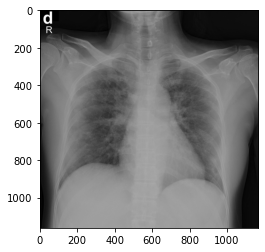

In [5]:
#visualize an image in the training set
train_list = []
for image_path in glob.glob(train_img_dir + "/*"):
    img = Image.open(image_path)
    train_list.append(img)
    
fig = plt.figure()
plt.imshow(train_list[5], cmap = "gray")

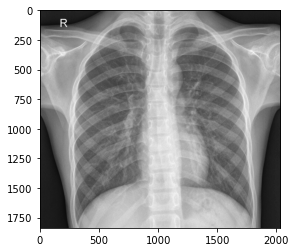

In [6]:
#Visualize an image in the test set
test_list = []
for image_path in glob.glob(test_img_dir + "/*"):
    img = Image.open(image_path)
    test_list.append(img)
    
fig = plt.figure()
plt.imshow(test_list[2], cmap = "gray")

In [7]:
print("There are " + str(len(test_list)) + " images in the test set")
print("There are " + str(len(train_list)) + " images in the training set")

There are 624 images in the test set
There are 5309 images in the training set


In [8]:
# Information about data set
df_metadata = pd.read_csv("coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv")
df_metadata.head()

#Label column is the target column for prediction 

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [9]:
set(df_metadata["Label"])  # two label: binary classification

{'Normal', 'Pnemonia'}

In [10]:
#divide train & test metadata
train_df = df_metadata[df_metadata["Dataset_type"] == "TRAIN"]
test_df = df_metadata[df_metadata["Dataset_type"] == "TEST"]


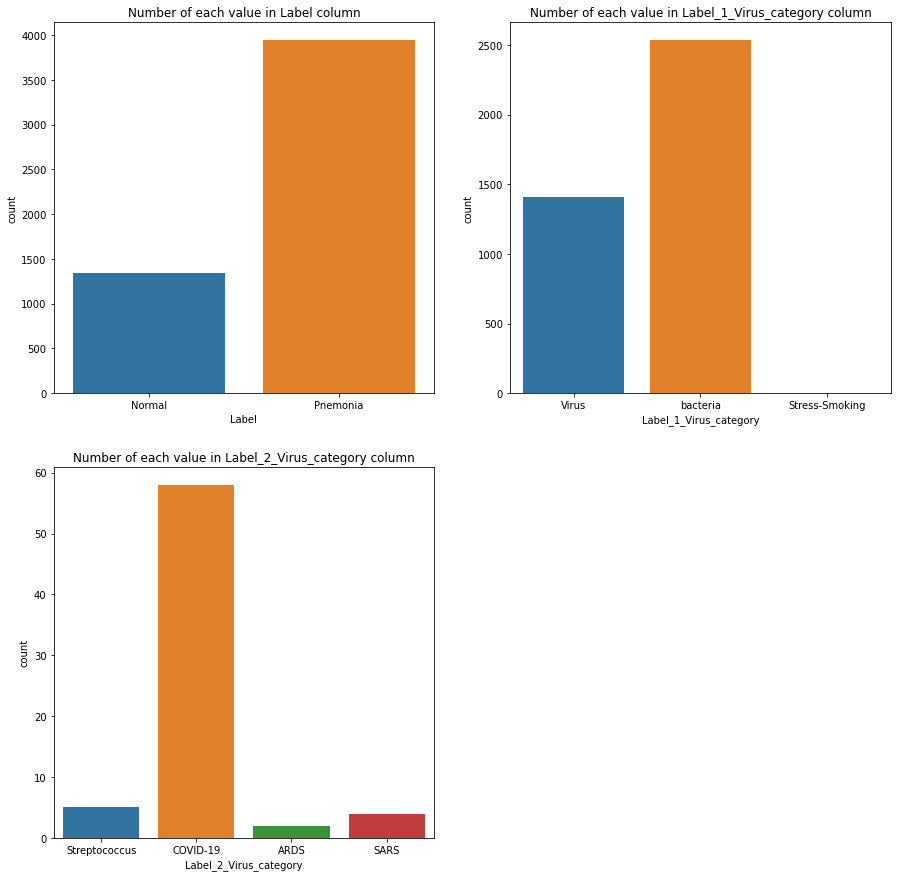

In [11]:
col = ['Label', 'Label_1_Virus_category', 'Label_2_Virus_category']

fig = plt.figure(figsize=(15, 15))
for i in range(3):
    ax = plt.subplot(2, 2, i + 1)
    ax = sns.countplot(x = col[i], data = train_df)
    ax.set_title(f'Number of each value in {col[i]} column')
plt.show()

In [12]:
train_df.fillna("unknown", inplace = True )
test_df.fillna("unknown", inplace = True )

C:\Users\nuras\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [13]:
train_df["Label_2_Virus_category"].value_counts()


unknown          5217
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64

In [14]:
train_df["Label_1_Virus_category"].value_counts()

bacteria          2535
Virus             1407
unknown           1342
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64

In [15]:
# Function creates working directories for labelled images

def create_dir():   
    try:
        os.makedirs('working/train/Pnemonia')
        os.makedirs('working/train/Normal')
        os.makedirs('working/test/Pnemonia')
        os.makedirs('working/test/Normal')
    except:
        pass

In [16]:
create_dir()  # call function

In [17]:
# Move training data with labels Pnemonia and Normal to created directiories

#COVID-19 case
train_pnemonia ='working/train/Pnemonia'
move_train_pnemonia = train_df[train_df.Label == 'Pnemonia']['X_ray_image_name'].values
for i in move_train_pnemonia:
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, train_pnemonia)
    
#Normal cases 
train_normal =  'working/train/Normal'
move_train_normal = train_df[train_df.Label == 'Normal']['X_ray_image_name'].values
for i in move_train_normal:
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, train_normal)

In [18]:
# Move test data with labels Pnemonia and Normal to created directiories


#COVID-19 cases
test_pnemonia = 'working/test/Pnemonia'
move_test_pnemonia = test_df[test_df.Label == 'Pnemonia']['X_ray_image_name'].values
for i in move_test_pnemonia :
    path = os.path.join(test_img_dir,i)
    shutil.copy(path,test_pnemonia)

#Normal cases
test_normal = 'working/test/Normal'
move_test_normal = test_df[test_df.Label == 'Normal']['X_ray_image_name'].values
for i in move_test_normal:
    path = os.path.join(test_img_dir,i)
    shutil.copy(path, test_normal)

In [27]:
# Model configuration
batch_size = 64
img_width, img_height, img_num_channels = 224,224,3
epochs = 40
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [28]:
#Data Augmentation

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   rotation_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode ='nearest',
                                   validation_split = 0.15)
train_generator = train_datagen.flow_from_directory('working/train/',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    subset = 'training')

valid_generator = train_datagen.flow_from_directory('working/train/',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    subset = 'validation')

test_datagen = ImageDataGenerator(rescale=1./255,  shear_range = 0.2,
                                   rotation_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode ='nearest')

test_generator = test_datagen.flow_from_directory('working/test/',
                                                  batch_size=batch_size,
                                                  class_mode='binary')




Found 4494 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
#Modelling, Transfer Learning 

# include_top = False, we eliminate the fully connected layers of ResNet architecture, instead
# we add to the structure a fully connected layer for prediction

base_model = tf.keras.applications.ResNet50(include_top = False, weights = "imagenet",
                                           input_shape = input_shape)

base_model.trainable = False # do not update pre-trained weights of the base_model during training

model = models.Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________


In [30]:
#add a earlystopping callback to stop the training if the model is not learning anymore
early_stopping = EarlyStopping (
min_delta = 0.01,
patience = 4,
restore_best_weights = True
)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data = valid_generator,  epochs = epochs, callbacks = [early_stopping])

Epoch 1/40
71/71 [==============================] - 667s 9s/step - loss: 0.7416 - accuracy: 0.6721 - val_loss: 0.5471 - val_accuracy: 0.7462
Epoch 2/40
71/71 [==============================] - 581s 8s/step - loss: 0.5548 - accuracy: 0.7486 - val_loss: 0.5241 - val_accuracy: 0.7462
Epoch 3/40
71/71 [==============================] - 511s 7s/step - loss: 0.5148 - accuracy: 0.7585 - val_loss: 0.4989 - val_accuracy: 0.7449
Epoch 4/40
71/71 [==============================] - 501s 7s/step - loss: 0.5147 - accuracy: 0.7429 - val_loss: 0.4886 - val_accuracy: 0.7525
Epoch 5/40
71/71 [==============================] - 502s 7s/step - loss: 0.4722 - accuracy: 0.7592 - val_loss: 0.4577 - val_accuracy: 0.7614
Epoch 6/40
71/71 [==============================] - 500s 7s/step - loss: 0.4586 - accuracy: 0.7769 - val_loss: 0.4411 - val_accuracy: 0.7614
Epoch 7/40
71/71 [==============================] - 500s 7s/step - loss: 0.4591 - accuracy: 0.7650 - val_loss: 0.4269 - val_accuracy: 0.7576
Epoch 8/40
71

In [31]:
model.save("model.h5") 

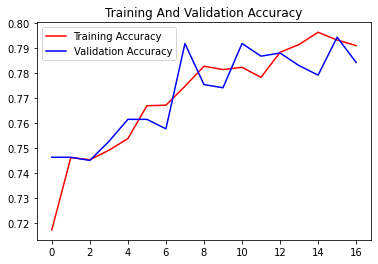

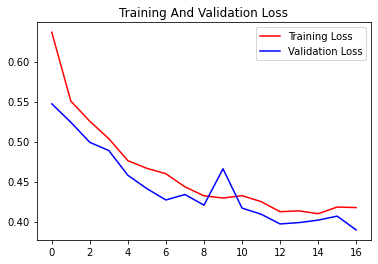

In [32]:
#learning curves

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs,acc,"r",label="Training Accuracy")
plt.plot(epochs,val_acc,"b",label="Validation Accuracy")
plt.title("Training And Validation Accuracy")

plt.legend()
plt.figure()

plt.plot(epochs,loss,"r",label="Training Loss")
plt.plot(epochs,val_loss,"b",label="Validation Loss")
plt.title("Training And Validation Loss")

plt.legend()
plt.show()

In [33]:
 #make predictions on test data, from classification report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)
y_test = test_generator.labels

print('Classification report:\n', classification_report(y_test, y_pred))
print('Accuracy score:\n', accuracy_score(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.38      1.00      0.55       234
           1       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624

Accuracy score:
 0.375


C:\Users\nuras\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
